In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from openslide import OpenSlide
import h5py
from omegaconf import OmegaConf
from maskWSI_fp_improved import MaskWSI_fp
from matplotlib import patches
from PIL import Image
import json
from shapely import Polygon
from shapely.plotting import plot_polygon
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Polygon
from collections import Counter
from tqdm import tqdm

from generate_patches_fp_improved import filter_patches_by_tissue_presence, filter_patches_by_tissue_presence_improved

In [2]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["tcga_brca_224_224_patches_jmcs"]

In [ ]:
DATA_ROOT = "<YOUR_PATH>//tcga-brca_breast_cancer_external_validation/WSI/"
DATA_ROOT

In [4]:
slides = np.sort(np.array( glob.glob( os.path.join(DATA_ROOT, "*.svs")) ))

In [ ]:
slides.shape, slides[:5]

In [6]:
# get slides used in the tcga-brca studsy cohort

In [7]:
labels_df = pd.read_csv("../02_patch_embeddings/labels_df.csv")

In [8]:
labels_df.shape

(731, 3)

In [9]:
labels_df = labels_df[labels_df.stage==3].reset_index(drop=True)

In [ ]:
labels_df

In [11]:
SLIDE_ID = labels_df.slide_id[3]

In [12]:
SLIDE_ID

'TCGA-A2-A0CL-01Z-00-DX1.5342E971-DCD2-42C4-B4FF-E6942A95829E'

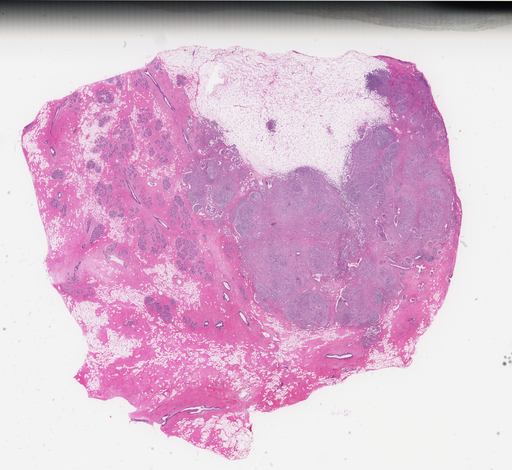

In [13]:
wsi = OpenSlide(DATA_ROOT + SLIDE_ID + ".svs")
wsi.get_thumbnail((512,512))

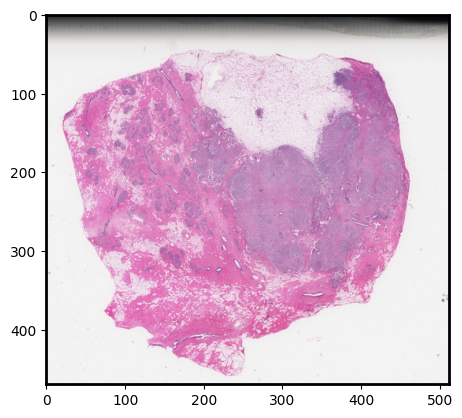

In [14]:
thumbnail  = wsi.get_thumbnail((512,512))
thumbnail = np.array(thumbnail)

fig, ax = plt.subplots()
ax.imshow(thumbnail)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.show()

In [15]:
float(wsi.properties["openslide.mpp-x"]), float(wsi.properties["openslide.mpp-y"])

(0.2505, 0.2505)

In [16]:
wsi.dimensions

(88331, 81058)

In [17]:
wsi.level_count

4

In [18]:
wsi.level_dimensions

((88331, 81058), (22082, 20264), (5520, 5066), (2760, 2533))

In [19]:
wsi.level_downsamples

(1.0, 4.000117277228153, 16.001193771205592, 32.002387542411185)

## Check maskWSI

In [28]:
patch_size = conf_preproc.patch_size
patch_level = conf_preproc.patch_level

patch_size, patch_level

(224, 2)

In [29]:
mask_wsi_fp = MaskWSI_fp( DATA_ROOT + SLIDE_ID + ".svs", patch_level, predefined_mask_dir=None, macenko=False)

Calculating mask...
Resolution of image to extract: (5520, 5066)
Current mask level: 3
Mask image shape: (2533, 2760, 3)
Target white on current image: 235.0
Scale factor: 112
scale factor: 112 width: 24 height: 22
Mask downsample image shape: (22, 24, 3) 200.54482323232324


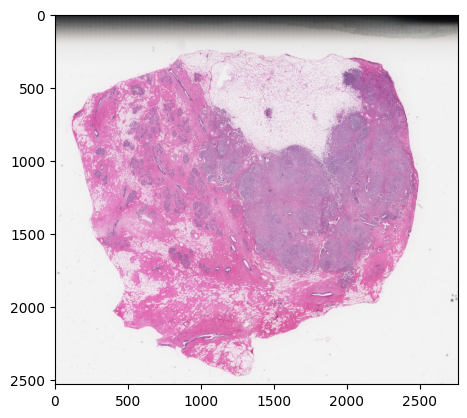

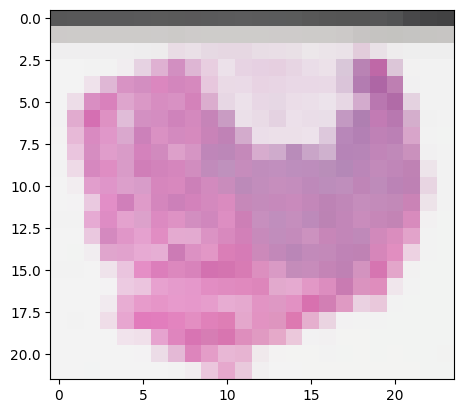

In [30]:
mask, w, h = mask_wsi_fp.get_mask(patch_size, mask_extrapolate=False, load_mask=False, ADAPT=-1, verbose=1)

In [31]:
mask.shape

(378, 2)

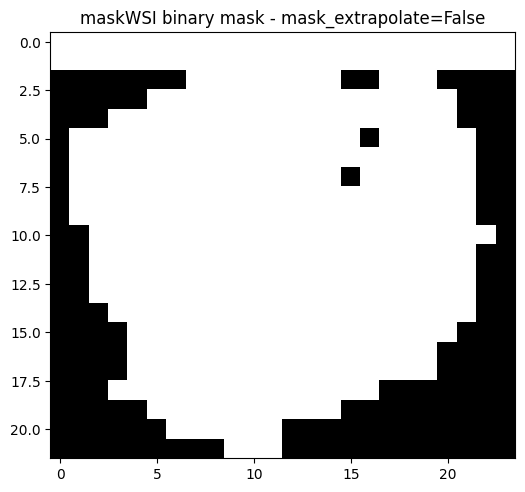

In [32]:
max_row = h
max_col = w

image = np.zeros((max_row, max_col), dtype=int)

for coord in mask:
    image[coord[0], coord[1]] = 1

plt.figure(figsize=(6, 6)) 
plt.imshow(image, cmap='gray')
plt.title('maskWSI binary mask - mask_extrapolate=False')
plt.show()

In [33]:
PATCH_SIZE = patch_size
LEVEL = patch_level

In [34]:
#coords = np.vstack( (mask[:,1], mask[:,0]) ).T*PATCH_SIZE*4**LEVEL #  coords should be given on level0 !

coords = np.vstack( (mask[:,1], mask[:,0]) ).T*PATCH_SIZE*int(wsi.level_downsamples[ patch_level ])     #  coords should be given on level0 !

In [35]:
wsi.level_downsamples

(1.0, 4.000117277228153, 16.001193771205592, 32.002387542411185)

In [36]:
coords.shape

(378, 2)

In [37]:
coords.min(0), coords.max(0)

(array([0, 0]), array([82432, 75264]))

In [39]:
# checking tissue filtering logic

In [42]:
coords_v3 = filter_patches_by_tissue_presence_improved(DATA_ROOT + SLIDE_ID + ".svs", 
                                                      coords, 
                                                      level=2,
                                                      patch_size=(224, 224),
                                                      save_patches=False, 
                                                      save_dir=None)

In [43]:
coords_v3.shape

(336, 2)

### Visualize

In [44]:
wsi_path = DATA_ROOT + SLIDE_ID + ".svs"
wsi = OpenSlide(wsi_path)

(-0.5, 2759.5, 2532.5, -0.5)

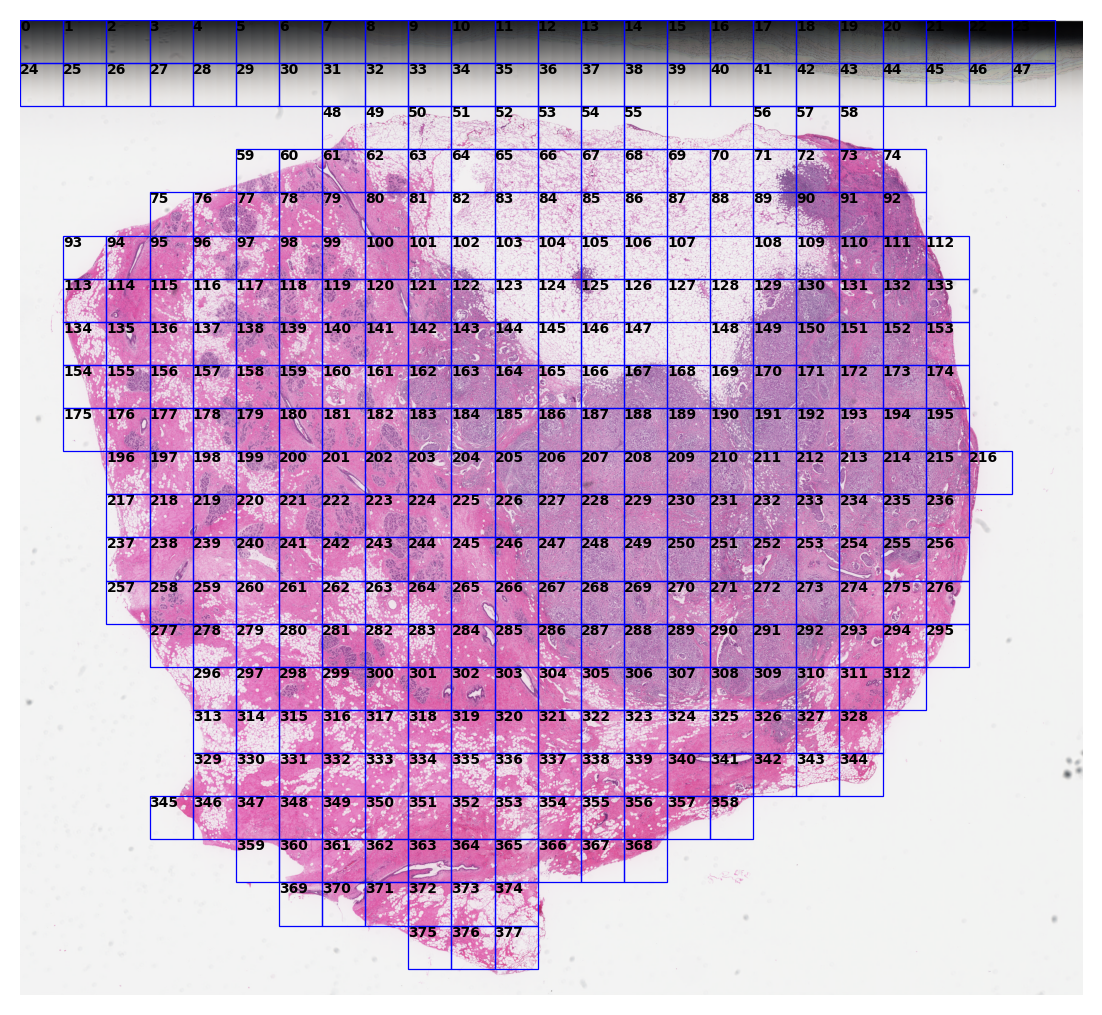

In [45]:
patchlev = 0 # as patch coords readed in are level 0 coords
vislev = 3 #3 # tricky to visualise on level 3 as the downscale factors are not constanc across the levels!

img_to_vis = np.array(wsi.read_region((0,0), vislev, wsi.level_dimensions[vislev] ).convert("RGB"))

#fig = plt.figure(figsize=(8, 8), dpi=200)

fig = plt.figure(figsize=(wsi.level_dimensions[vislev][0]/400, wsi.level_dimensions[vislev][1]/400), dpi=200)

ax = fig.add_subplot(111)


coords_viz =  coords // int(wsi.level_downsamples[vislev]) # bring coords to vislev

patch_scale_factor = int(wsi.level_downsamples[vislev]) // int(wsi.level_downsamples[patch_level]) # bring patch size to vislev


for idx, c in enumerate(coords_viz):

    rect = patches.Rectangle((c[0], c[1]), ( PATCH_SIZE // patch_scale_factor),
                          ( PATCH_SIZE // patch_scale_factor ),  
                          facecolor="none", edgecolor='blue', linestyle='-', linewidth=0.45)


    ax.add_patch(rect)
    
    # Add patch number as text in the top left corner of the rectangle
    ax.text(c[0], c[1]+(PATCH_SIZE//2**(vislev-patchlev)), str(idx), fontsize=5, color='black', weight='bold')

    # Add coords
    # commented out because plot is too crowded
    #ax.text(c[0], c[1], f'({c[0]},{c[1]})', fontsize=8, color='blue')

    
ax.imshow(img_to_vis)
ax.axis('off')

(-0.5, 2759.5, 2532.5, -0.5)

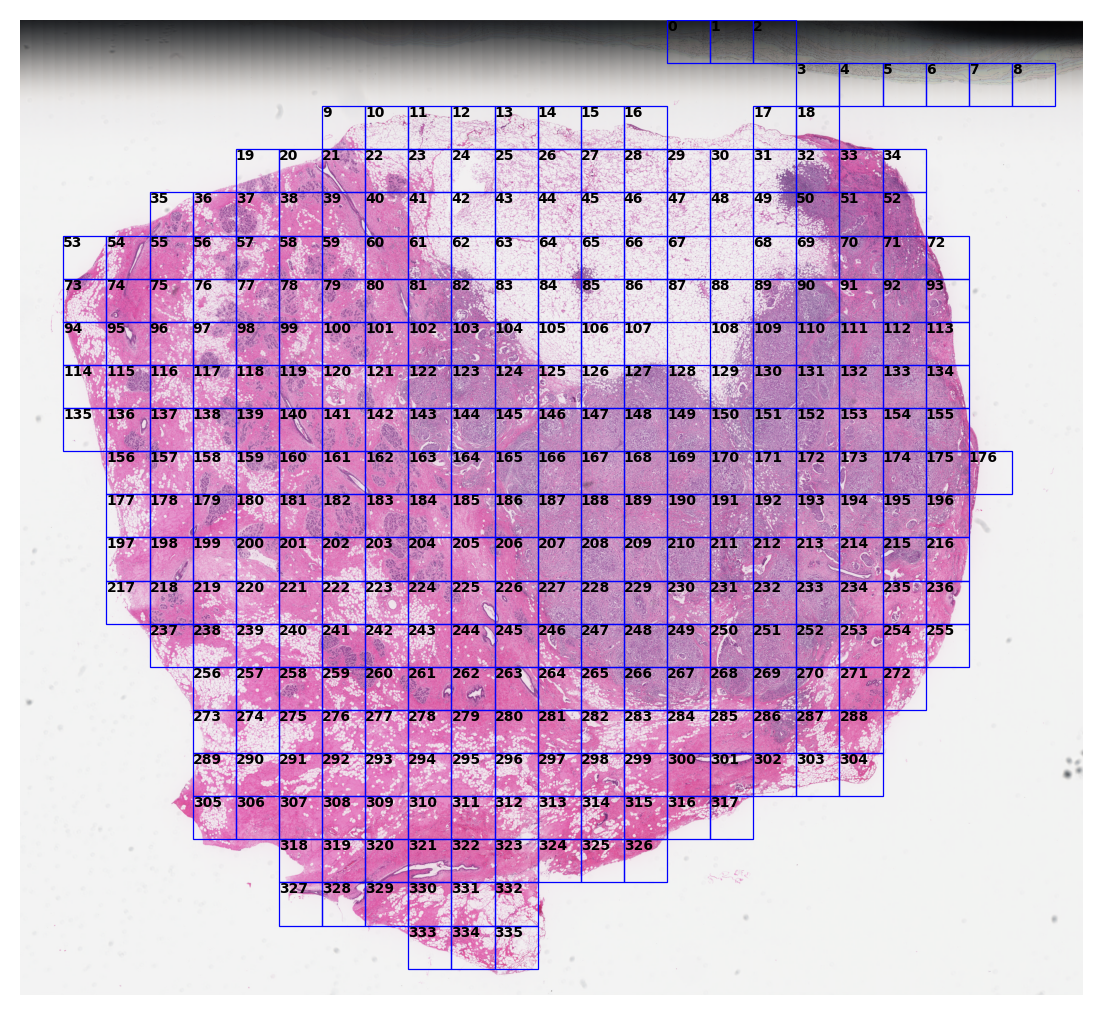

In [47]:
patchlev = 0 # as patch coords readed in are level 0 coords
vislev = 3 #3 # tricky to visualise on level 3 as the downscale factors are not constanc across the levels!

img_to_vis = np.array(wsi.read_region((0,0), vislev, wsi.level_dimensions[vislev] ).convert("RGB"))

#fig = plt.figure(figsize=(8, 8), dpi=200)

fig = plt.figure(figsize=(wsi.level_dimensions[vislev][0]/400, wsi.level_dimensions[vislev][1]/400), dpi=200)

ax = fig.add_subplot(111)


coords_viz =  coords_v3 // int(wsi.level_downsamples[vislev]) # bring coords to vislev

patch_scale_factor = int(wsi.level_downsamples[vislev]) // int(wsi.level_downsamples[patch_level]) # bring patch size to vislev


for idx, c in enumerate(coords_viz):

    rect = patches.Rectangle((c[0], c[1]), ( PATCH_SIZE // patch_scale_factor),
                          ( PATCH_SIZE // patch_scale_factor ),  
                          facecolor="none", edgecolor='blue', linestyle='-', linewidth=0.45)


    ax.add_patch(rect)
    
    # Add patch number as text in the top left corner of the rectangle
    ax.text(c[0], c[1]+(PATCH_SIZE//2**(vislev-patchlev)), str(idx), fontsize=5, color='black', weight='bold')

    # Add coords
    # commented out because plot is too crowded
    #ax.text(c[0], c[1], f'({c[0]},{c[1]})', fontsize=8, color='blue')

    
ax.imshow(img_to_vis)
ax.axis('off')

### check patch extraction

In [ ]:
coords, images = load_h5_file_extracted_patches(f"<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_extraction_data_224/extracted_patches_224_level4_macenko_bracs/{SLIDE_ID}.h5")

In [56]:
coords.shape, images.shape

((336, 2), (336, 224, 224, 3))

In [57]:
coords.min(0), coords.max(0)

(array([3584,    0]), array([82432, 75264]))

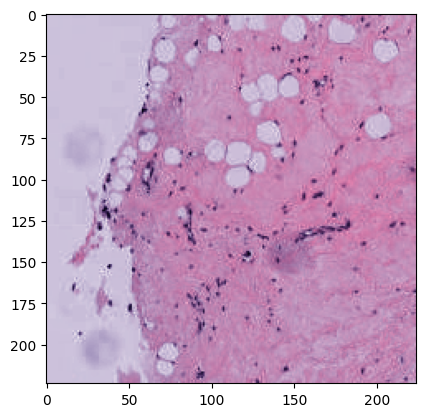

In [58]:
plt.imshow(images[197])

### check saved embeddings

In [ ]:
coords, features = load_h5_file_features( "<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_embs_1024_level4_macenko/TCGA-A2-A0CL-01Z-00-DX1.5342E971-DCD2-42C4-B4FF-E6942A95829E.h5" )

In [64]:
coords.shape, features.shape

((336, 2), (336, 1024))

In [65]:
coords.min(0), coords.max(0)

(array([3584,    0]), array([82432, 75264]))

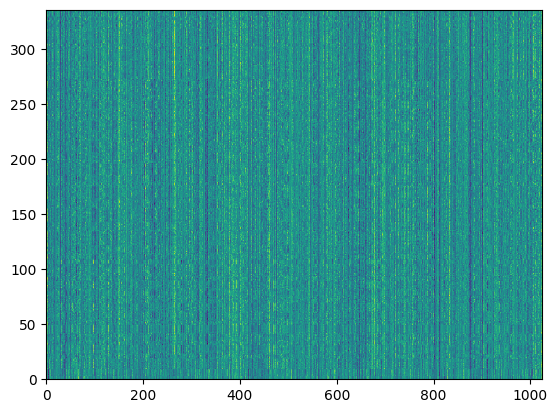

In [66]:
plt.pcolormesh(features)